In [23]:
from model import LinearRegression
from scaler import StandardScaler
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [24]:
train_data = pd.read_csv('input\\train.csv', encoding='big5')
train_data.drop(columns=u'測站', inplace=True)
train_data.replace('NR', 0, inplace=True)

for i in range(24):
    train_data['%d' % i] = train_data['%d' % i].astype('float64')
measure_name = train_data.iloc[0:18, 1]

result = []
day = 1
month = 1

for i in range(0, train_data.shape[0], 18):
    temp = train_data.iloc[i:i+18, 2:].T
    temp.columns = measure_name
    temp.insert(loc=0, column='month', value='%d' % month)
    temp.insert(loc=1, column='day', value='%d' % day)
    temp.insert(loc=2, column='hr', value=temp.index)
    result.append(temp)
    if day < 20:
        day += 1
    else:
        day = 1
        month += 1
train = pd.concat(result, ignore_index=True)
train.columns.name = None

test_data = pd.read_csv('input\\test.csv', header=None, encoding='big5')
test_data.replace('NR', 0, inplace=True)
for i in range(2, 11):
    test_data.iloc[:, i] = test_data.iloc[:, i].astype('float64')
measure_name = test_data.iloc[0:18, 1]

result = []
id_ = 0

for i in range(0, test_data.shape[0], 18):
    temp = test_data.iloc[i:i+18, 2:].T
    temp.columns = measure_name
    temp.insert(loc=0, column='ID', value='id_%d' % id_)
    temp.insert(loc=1, column='hr', value=temp.index-1)
    result.append(temp)
    id_ +=1
        
test = pd.concat(result, ignore_index=True)
test.columns.name = None

train['month'] = train['month'].astype('int64')
train['day'] = train['day'].astype('int64')
train['hr'] = train['hr'].astype('int64')

train['Y'] = train['PM2.5'].shift(-1)
train.drop(train[(train['hr'] == 23) & (train['day'] == 20)].index, inplace=True)

train.tail()

,month,day,hr,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,...,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR,Y
5754,12,20,18,15.0,1.8,0.55,0.20,1.3,19.0,21.0,...,49.0,0.0,73.0,3.4,2.0,100.0,121.0,1.5,1.1,37.0
5755,12,20,19,14.0,1.8,0.48,0.15,1.0,13.0,14.0,...,37.0,0.0,76.0,2.6,1.9,109.0,97.0,1.0,1.4,28.0
5756,12,20,20,13.0,1.8,0.47,0.16,1.5,13.0,15.0,...,28.0,0.0,80.0,2.2,1.9,108.0,107.0,1.7,1.3,17.0
5757,12,20,21,13.0,1.8,0.51,0.16,1.5,13.0,15.0,...,17.0,0.0,82.0,2.3,1.9,114.0,118.0,1.5,1.6,24.0
5758,12,20,22,13.0,1.8,0.57,0.19,1.1,13.0,14.0,...,24.0,0.0,84.0,2.3,2.0,108.0,100.0,2.0,1.8,29.0


In [25]:
hr_to_train = 9
train_XY = pd.DataFrame(train[['day', 'hr', 'Y']])
test_X = pd.DataFrame(test['ID'])

# features = ['AMB_TEMP', 'CH4', 'CO', 'NMHC', 'NO2', 'NOx', 'O3', 'PM10', 'RH', 'SO2', 'THC', 'PM2.5']
features = ['PM10', 'NO2', 'PM2.5', 'SO2']
scaler = dict()

for ft in features:
    train_XY['%s_P0' % ft] = train[ft].copy()
    test_X['%s_P0' % ft] = test[ft].copy()
#     scaler[ft] = StandardScaler()
#     scaler[ft].fit(train[ft].to_numpy())
#     train_XY['%s_P0' % ft] = scaler[ft].transform(train[ft].to_numpy())
#     test_X['%s_P0' % ft] = scaler[ft].transform(test[ft].to_numpy())
    for i in range(1, hr_to_train):
#         train_XY['%s_P%d' % (ft, i)] = scaler[ft].transform(train[ft].shift(i).to_numpy())
#         test_X['%s_P%d' % (ft, i)] = scaler[ft].transform(test[ft].shift(i).to_numpy())
        train_XY['%s_P%d' % (ft, i)] = train[ft].shift(i)
        test_X['%s_P%d' % (ft, i)] = test[ft].shift(i)
        
condition = (train_XY['hr'] >= 0) & (train_XY['hr'] <= hr_to_train-1) & (train_XY['day'] == 1)
train_XY.drop(train[condition].index, inplace=True)
train_XY.drop(columns='hr', inplace=True)
train_XY.reset_index(drop=True, inplace=True)

train_XY.head()

,day,Y,PM10_P0,PM10_P1,PM10_P2,PM10_P3,PM10_P4,PM10_P5,PM10_P6,PM10_P7,...,PM2.5_P8,SO2_P0,SO2_P1,SO2_P2,SO2_P3,SO2_P4,SO2_P5,SO2_P6,SO2_P7,SO2_P8
0,1,41.0,38.0,11.0,2.0,4.0,12.0,25.0,35.0,48.0,...,39.0,15.0,5.1,1.6,1.5,1.4,1.9,1.6,1.7,2.0
1,1,44.0,56.0,38.0,11.0,2.0,4.0,12.0,25.0,35.0,...,36.0,4.5,15.0,5.1,1.6,1.5,1.4,1.9,1.6,1.7
2,1,33.0,64.0,56.0,38.0,11.0,2.0,4.0,12.0,25.0,...,35.0,2.7,4.5,15.0,5.1,1.6,1.5,1.4,1.9,1.6
3,1,37.0,56.0,64.0,56.0,38.0,11.0,2.0,4.0,12.0,...,31.0,3.5,2.7,4.5,15.0,5.1,1.6,1.5,1.4,1.9
4,1,36.0,57.0,56.0,64.0,56.0,38.0,11.0,2.0,4.0,...,28.0,3.6,3.5,2.7,4.5,15.0,5.1,1.6,1.5,1.4


Text(0.5, 1.0, 'train feature corr')

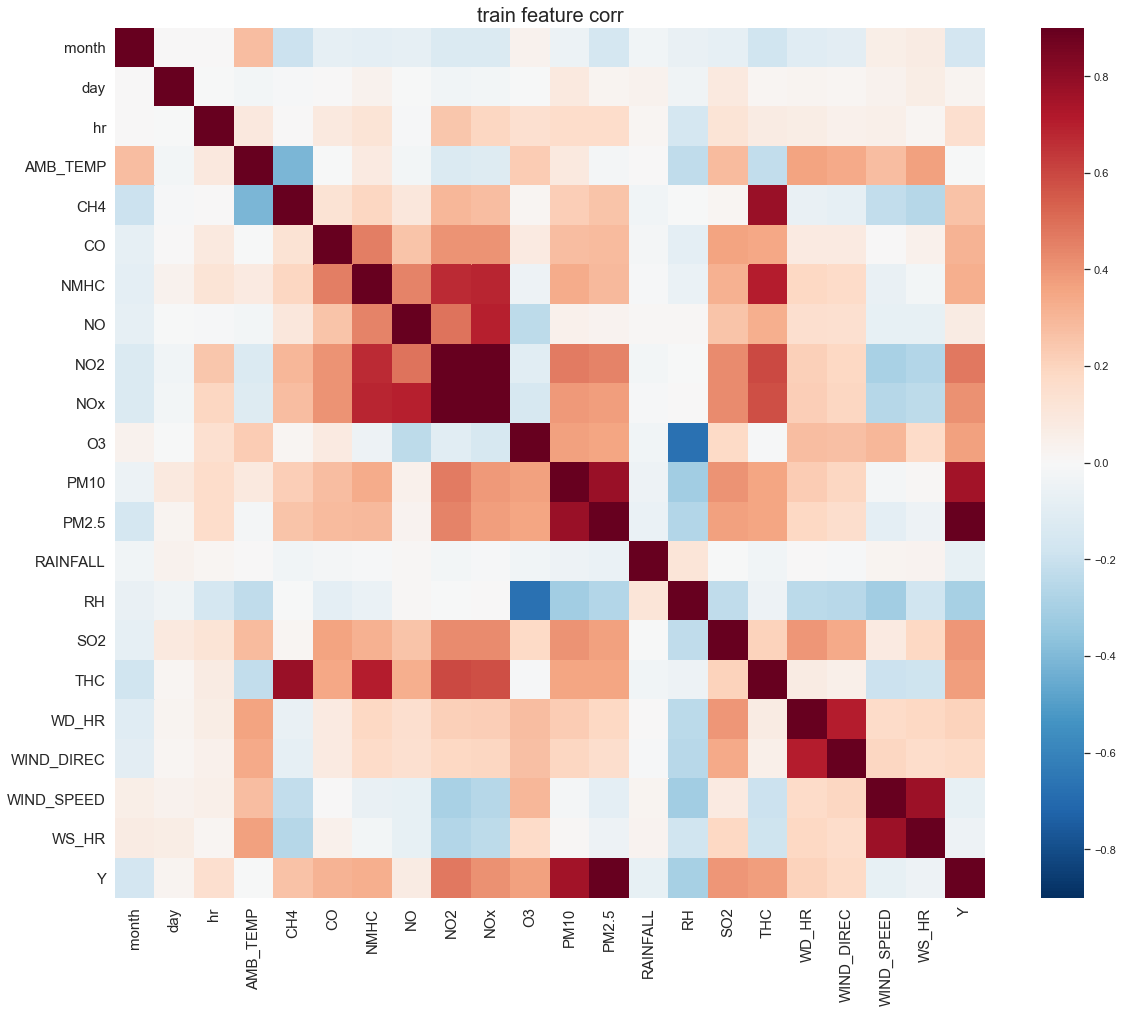

In [4]:
sns.set(context="paper", font="monospace")
sns.set(style="white")
f, ax = plt.subplots(figsize=(20,16))
train_corr = train.corr()
sns.heatmap(train_corr, ax=ax, vmin=-.9, vmax=.9, square=True, cmap="RdBu_r")
ax.set_xticklabels(train_corr.index, size=15)
ax.set_yticklabels(train_corr.columns, size=15)
ax.set_title('train feature corr', fontsize=20)

In [26]:
trainX_set = []
trainX_set.append(train_XY[train_XY['day'] <= 5].drop(columns=['day', 'Y']).reset_index(drop=True))
trainX_set.append(train_XY[(train_XY['day'] > 5) & (train_XY['day'] <= 10)].drop(columns=['day', 'Y']).reset_index(drop=True))
trainX_set.append(train_XY[(train_XY['day'] > 10) & (train_XY['day'] <= 15)].drop(columns=['day', 'Y']).reset_index(drop=True))
trainX_set.append(train_XY[(train_XY['day'] > 15) & (train_XY['day'] <= 20)].drop(columns=['day', 'Y']).reset_index(drop=True))

train_Y = train_XY[['day', 'Y']].copy()
trainY_set = []
trainY_set.append(train_Y[train_Y['day'] <= 5].drop(columns='day').reset_index(drop=True))
trainY_set.append(train_Y[(train_Y['day'] > 5) & (train_Y['day'] <= 10)].drop(columns='day').reset_index(drop=True))
trainY_set.append(train_Y[(train_Y['day'] > 10) & (train_Y['day'] <= 15)].drop(columns='day').reset_index(drop=True))
trainY_set.append(train_Y[(train_Y['day'] > 15) & (train_Y['day'] <= 20)].drop(columns='day').reset_index(drop=True))

In [27]:
lr = []
score = []
loss_trend = []
weight = []
for i in range(4):
    all_ = list(range(4))
    all_.remove(i)
    to_train_X = pd.concat([trainX_set[all_[0]], trainX_set[all_[1]], trainX_set[all_[2]]])
    to_train_Y = pd.concat([trainY_set[all_[0]], trainY_set[all_[1]], trainY_set[all_[2]]])
    to_test_X = trainX_set[i].copy()
    to_test_Y = trainY_set[i].copy()
    
    lr.append(LinearRegression(max_iter=20000, eta0=1, learning_rate='Adagrad'))
    weight.append(lr[i].fit(to_train_X.to_numpy(), to_train_Y['Y'].to_numpy()))
    loss_trend.append(lr[i].loss_trend())
    score.append(lr[i].score(to_test_X.to_numpy(), to_test_Y['Y'].to_numpy()))

In [28]:
for i in range(4):
    print(loss_trend[i][-3:])
    print(score[i])

[5.706410559488585, 5.706410555816679, 5.706410552146452]
0.8443981134303203
[6.094948650332614, 6.094948641109991, 6.094948631890454]
0.8881171806406061
[5.791800218594082, 5.791800212895231, 5.79180020719847]
0.8639927101977951
[5.828430091641613, 5.8284300886506095, 5.828430085660723]
0.8821825659268343


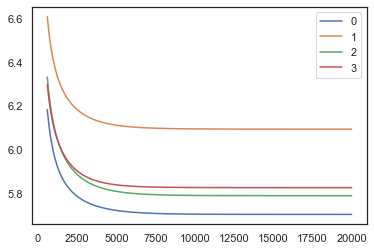

In [29]:
for i in range(4):
    plt.plot(np.arange(600, len(loss_trend[i])+1), loss_trend[i][599:], label=i)
plt.legend(loc='upper right')

In [9]:
kk_x = train_XY.sample(n=240, random_state=1).drop(columns=['day', 'Y'])
kk_y = train_Y.sample(n=240, random_state=1)

In [10]:
for i in range(4):
    print(lr[i].score(kk_x.to_numpy(), kk_y['Y'].to_numpy()))

0.8794248939687377
0.8813620009494189
0.8835858846713471
0.882999034069929


In [19]:
lr_all = LinearRegression(max_iter=1000, eta0=1, learning_rate='Adagrad')
lr_all.fit(train_XY.drop(columns=['day', 'Y']).to_numpy(), train_Y['Y'].to_numpy())

array([ 0.0061075 ,  0.09916107, -0.01878996, -0.01475092,  0.01617899,
       -0.00993364, -0.01090003,  0.00423509,  0.00915012, -0.01012456,
        0.18594766,  0.01243927, -0.06238102, -0.01359   ,  0.01962363,
        0.00341617, -0.00224325, -0.02693688, -0.02983353,  0.78330296,
        0.11841914, -0.25704732,  0.10305637,  0.0413809 , -0.01099055,
        0.01542225,  0.01716574,  0.01083465,  0.30948467,  0.08611289,
       -0.06949455, -0.01123013, -0.01328933, -0.04576842, -0.04664405,
       -0.00191803, -0.14882831])

In [20]:
lr_all.loss_trend()[-3:]

[6.162927464783225, 6.162602744939302, 6.1622785929787]

In [21]:
test_X_9 = test_X.iloc[[i for i in range(8, 2160, 9)]]
set(train_XY.columns) - set(test_X_9.columns)

{'Y', 'day'}

In [22]:
test_Y = pd.DataFrame()
test_Y['id'] = ['id_%d' % i for i in range(240)]
test_Y['value'] = lr_all.predict(test_X_9.drop(columns='ID').to_numpy())
test_Y.head()

,id,value
0,id_0,4.585654
1,id_1,15.884384
2,id_2,28.656570
3,id_3,5.222031
4,id_4,29.764106


In [15]:
test_Y.to_csv('./output/submission_1090709_4.csv', index=None)